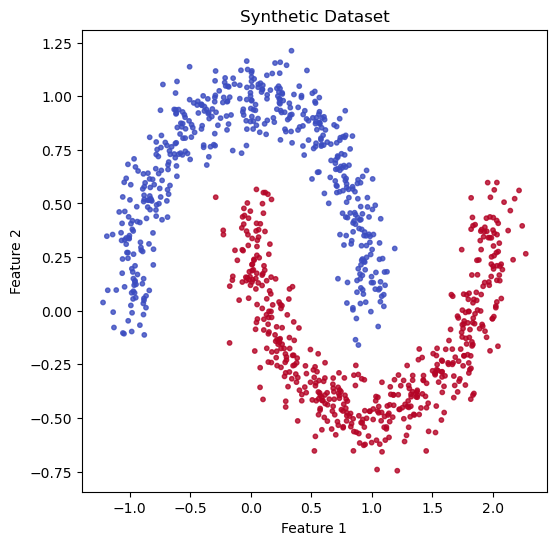

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

#######################################
# 1) SYNTHETIC DATASET
#######################################
# Generate synthetic data (2D, two classes)
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Visualize the dataset
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=10, alpha=0.8)
plt.title("Synthetic Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
#######################################
# 2) MLP CLASSIFIER
#######################################
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 2)  # Output layer: 2 classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize model, optimizer, and loss function
model = MLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [3]:
# Train-test split
train_idx = np.random.choice(len(X), int(0.8 * len(X)), replace=False)
test_idx = np.setdiff1d(np.arange(len(X)), train_idx)
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

In [4]:
#######################################
# 3) TRAIN THE CLASSIFIER
#######################################
model.train()
for epoch in range(400):
    optimizer.zero_grad()
    logits = model(X_train.to(device))
    loss = criterion(logits, y_train.to(device))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")
X_train = X_train.to('cpu')
y_train = y_train.to('cpu')

Epoch 20, Loss: 0.3433
Epoch 40, Loss: 0.2220
Epoch 60, Loss: 0.1544
Epoch 80, Loss: 0.0747
Epoch 100, Loss: 0.0263
Epoch 120, Loss: 0.0115
Epoch 140, Loss: 0.0068
Epoch 160, Loss: 0.0047
Epoch 180, Loss: 0.0036
Epoch 200, Loss: 0.0028
Epoch 220, Loss: 0.0023
Epoch 240, Loss: 0.0019
Epoch 260, Loss: 0.0016
Epoch 280, Loss: 0.0013
Epoch 300, Loss: 0.0011
Epoch 320, Loss: 0.0010
Epoch 340, Loss: 0.0009
Epoch 360, Loss: 0.0008
Epoch 380, Loss: 0.0007
Epoch 400, Loss: 0.0006


In [5]:
#######################################
# 4) VISUALIZE DECISION BOUNDARY
#######################################
# Create a grid of points in the feature space
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 100),
    np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 100)
)
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

In [38]:
T = 5

# Compute predictions and energy
with torch.no_grad():
    logits = model(grid.to(device))
    probs = torch.softmax(logits, dim=1)
    energy_0 = torch.log(probs[:, 0]).to('cpu').numpy().reshape(xx.shape)
    energy_1 = torch.log(probs[:, 1]).to('cpu').numpy().reshape(xx.shape)
    energy = -1 * T * torch.logsumexp(logits / T, dim=1).to('cpu').numpy().reshape(xx.shape)
    predictions = torch.argmax(probs, dim=1).to('cpu').numpy().reshape(xx.shape)
    
grid = grid.cpu()

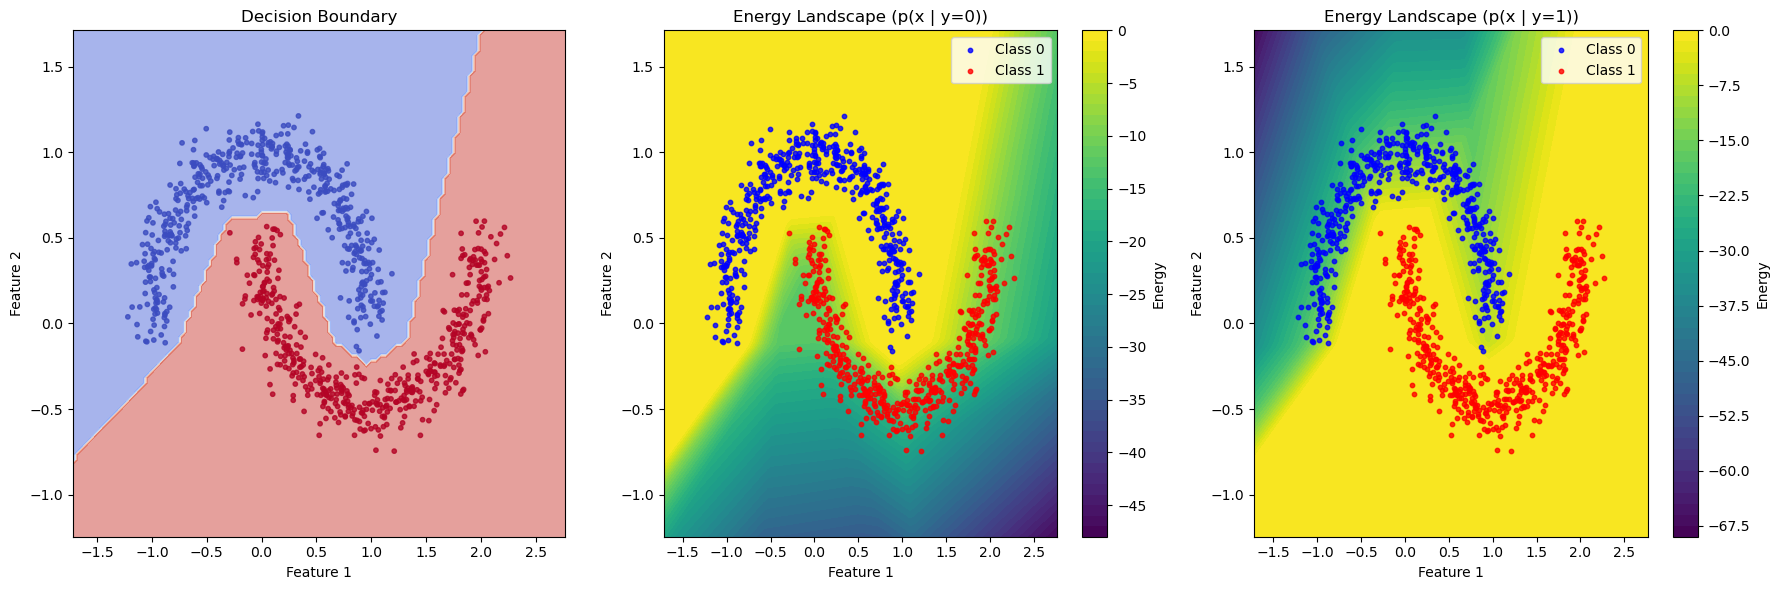

In [39]:
# Plot the decision boundary and energy landscape
plt.figure(figsize=(18, 6))

# Plot decision boundary
plt.subplot(1, 3, 1)
plt.contourf(xx, yy, predictions, alpha=0.5, cmap="coolwarm")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=10, alpha=0.8)
plt.title("Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Plot energy landscape for class 0
plt.subplot(1, 3, 2)
plt.contourf(xx, yy, energy_0, levels=50, cmap="viridis")
plt.colorbar(label="Energy")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", s=10, alpha=0.8, label="Class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", s=10, alpha=0.8, label="Class 1")
plt.title("Energy Landscape (p(x | y=0))")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

# Plot energy landscape for class 0
plt.subplot(1, 3, 3)
plt.contourf(xx, yy, energy_1, levels=50, cmap="viridis")
plt.colorbar(label="Energy")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", s=10, alpha=0.8, label="Class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", s=10, alpha=0.8, label="Class 1")
plt.title("Energy Landscape (p(x | y=1))")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

plt.tight_layout()
plt.show()

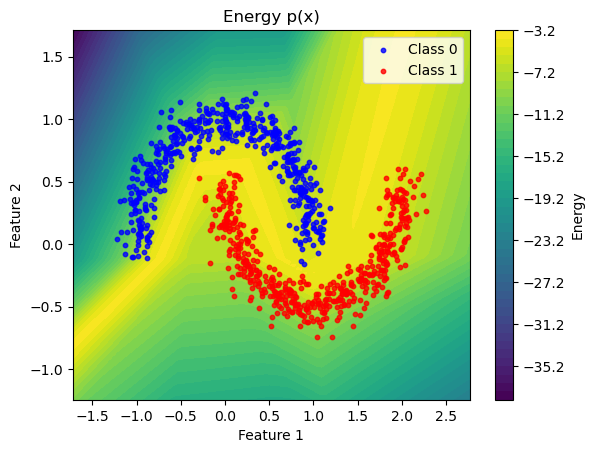

In [40]:
plt.figure()
plt.contourf(xx, yy, energy, levels=50, cmap="viridis")
plt.colorbar(label="Energy")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", s=10, alpha=0.8, label="Class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", s=10, alpha=0.8, label="Class 1")
plt.title("Energy p(x)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [53]:
import torch.nn.functional as F
import math

#######################################
# 5) ENERGY FUNCTION: E(x) = -log p(y|x)
#######################################
def energy_function(model, x, target_class):
    """
    x: Tensor of shape [1, 1, 28, 28].
    target_class: integer (0..9).
    Returns: scalar (the negative log-likelihood).
    """
    # Forward pass
    logits = model(x)
    energy = -1 * T * torch.logsumexp(logits / T, dim=1)
    # We pick the log-prob of 'target_class'
    return -1 * energy[0]

#######################################
# 6) LANGEVIN SAMPLING
#######################################
def langevin_sampling(model, target_class=0, step_size=0.02):
    """
    Use gradient-based MCMC (Langevin Dynamics) to sample an image x
    from the unnormalized density E(x) = -log p(target_class | x).

    Returns a single image of shape [1, 1, 28, 28].
    """
    # 6.1) Initialize x to random noise on the same device as model
    x = torch.rand((1, 2), device=device, requires_grad=True)
    x.data = -1 + (1 - (-1)) * x.data

    # i = 0
    j = 0
    # e = energy_function(model, x, target_class)
    
    while j < 100:
        # Zero-out gradient from previous step
        if x.grad is not None:
            x.grad.zero_()
        
        # Compute energy
        e = energy_function(model, x, target_class)
        
        # Backprop to get gradient
        e.backward()
        
        # Langevin update:
        with torch.no_grad():
            # x <- x - step_size * grad + noise
            x = x - (step_size / 2) * x.grad + math.sqrt(step_size) * torch.randn_like(x)
        
        # Detach from graph to avoid accumulating history
        x = x.detach()
        x.requires_grad_()
        
        # (Optional) print intermediate status
        if (j+1) % 1000 == 0:
            print(f"  Step {j+1}, Energy: {-1 * e.item():.6f}")
        # i += 1
        j += 1
        # if i == 5000:
        #     if e.item() > 1e-3:
        #         i = i - 1
    return x.detach().cpu().numpy()

In [54]:
# Generate samples via Langevin dynamics
print("Generating samples in 2D space...")
samples = []
for idx in range(100):
    print('#########################################')
    samples.append(langevin_sampling(model))
    print('sample {} generated'.format(idx + 1))
    print('#########################################')
samples = np.concatenate(samples, axis=0)

Generating samples in 2D space...
#########################################
sample 1 generated
#########################################
#########################################
sample 2 generated
#########################################
#########################################
sample 3 generated
#########################################
#########################################
sample 4 generated
#########################################
#########################################
sample 5 generated
#########################################
#########################################
sample 6 generated
#########################################
#########################################
sample 7 generated
#########################################
#########################################
sample 8 generated
#########################################
#########################################
sample 9 generated
#########################################
#######################################

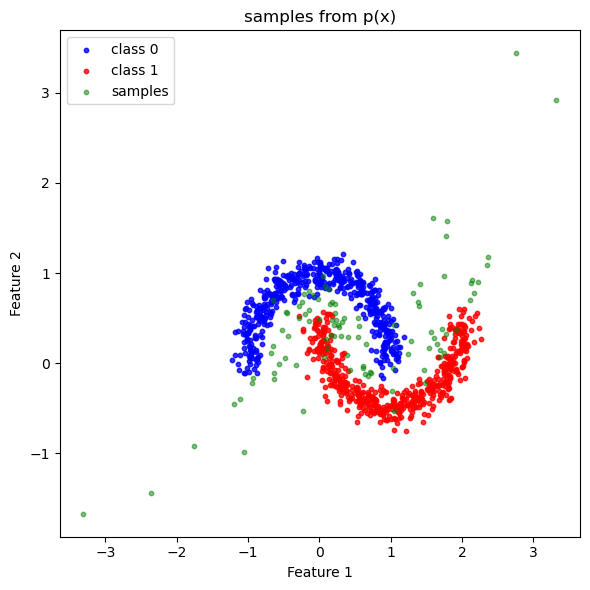

In [57]:
# Plot energy landscape for class 0
plt.figure(figsize=(6, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", s=10, alpha=0.8, label="class 0")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", s=10, alpha=0.8, label="class 1")
plt.scatter(samples[:, 0], samples[:, 1], label="samples", s=10, alpha=0.5, color="green")
plt.title("samples from p(x)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

plt.tight_layout()
plt.show()